# Project 2.0 ADD-ON: Autoencoder-based Player Outliers

*Experimental notebook separate from the required COMP721 deliverables.* This workflow trains a deep autoencoder on the engineered player feature matrix to surface players whose multi-dimensional stat profiles cannot be reconstructed well by the league-wide patterns.


## Advantages and Disadvantages of this Add-on
- **Advantages:** Captures non-linear relationships, highlights subtle standout careers beyond MAD/IsolationForest, and provides an additional anomaly score for triangulation.
- **Disadvantages:** Requires extra dependencies (TensorFlow/Keras), hyperparameter tuning, and careful interpretation of reconstruction errors; more computationally intensive than robust z-scores.


## How to run
1. Ensure requirements (including TensorFlow/Keras) are installed.
2. Launch Jupyter from the project root to resolve `src` imports.
3. Execute cells sequentially; outputs are saved to `figures/` and `tables/` with `autoencoder_` prefixes.

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'addons':
    PROJECT_ROOT = PROJECT_ROOT.parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

FIG_DIR = PROJECT_ROOT / 'figures'
TABLE_DIR = PROJECT_ROOT / 'tables'
FIG_DIR.mkdir(exist_ok=True)
TABLE_DIR.mkdir(exist_ok=True)

sns.set_theme(style='whitegrid')
from src.core import data_loading as core_dl
from src.core import feature_engineering as core_fe
from src.core import models_outliers as core_out
from src.addons import autoencoder_outliers as add_auto


## Load player data and engineer features

In [2]:
players = core_dl.load_players()
reg_career = core_dl.load_player_regular_season_career()
playoff_career = core_dl.load_player_playoffs_career()
allstar = core_dl.load_player_allstar()

player_features = core_fe.build_player_feature_table(
    players_df=players,
    reg_career_df=reg_career,
    playoff_career_df=playoff_career,
    allstar_df=allstar,
    min_games=82,
)
player_features.head()


,ilkid,player_name,position,first_season,last_season,gp,minutes,ppg,rpg,apg,...,playoff_fga,playoff_fgm,playoff_fta,playoff_ftm,playoff_tpa,playoff_tpm,playoff_rpg,allstar_games,allstar_minutes,allstar_points
0,ABDELAL01,Alaa Abdelnaby,F,1990,1994,256,3200.0,5.722656,3.304688,0.332031,...,40.0,18.0,4.0,2.0,0.0,0.0,1.176471,0.0,0.0,0.0
1,ABDULKA01,Kareem Abdul-Jabbar,C,1969,1988,1560,57446.0,24.607051,11.179487,3.628205,...,4422.0,2356.0,1419.0,1050.0,4.0,0.0,10.468354,19.0,548.0,264.0
2,ABDULMA01,Mahmo Abdul-Rauf,G,1990,2000,586,15633.0,14.595563,1.854949,3.547782,...,187.0,69.0,45.0,43.0,49.0,14.0,1.533333,0.0,0.0,0.0
3,ABDULTA01,Tariq Abdul-Wahad,G,1997,2002,236,4808.0,7.754237,3.288136,1.127119,...,63.0,24.0,24.0,20.0,3.0,0.0,3.153846,0.0,0.0,0.0
4,ABDURSH01,Shareef Abdur-Rahim,F,1996,2004,672,24862.0,19.848214,8.145833,2.748512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,21.0,9.0


## Train autoencoder and compute anomaly scores

In [3]:
numeric_cols = player_features.select_dtypes(include=[np.number]).columns
feature_matrix = player_features[numeric_cols].fillna(0.0)

auto_model, scaler, auto_errors = add_auto.train_autoencoder(
    feature_matrix,
    latent_dim=8,
    epochs=40,
    batch_size=128,
)

player_features['autoencoder_error'] = auto_errors
key_stats = [col for col in ['impact_score', 'ppg', 'apg', 'rpg', 'fg_pct', 'usage_proxy'] if col in player_features.columns]

top_auto = add_auto.get_top_anomalies(
    player_features[key_stats],
    player_features['player_name'],
    auto_errors,
    top_k=20,
)

auto_table_path = TABLE_DIR / 'top_outliers_autoencoder.csv'
top_auto.to_csv(auto_table_path, index=False)
print(f'Saved top autoencoder outliers table to {auto_table_path}')
top_auto.head()


Saved top autoencoder outliers table to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\tables\top_outliers_autoencoder.csv


,player_id,reconstruction_error,impact_score,ppg,apg,rpg,fg_pct,usage_proxy
1513,Mike Novak,4.508252,5.051200,3.360000,1.400000,0.016000,0.310212,892.680000
1775,Bill Russell,1.503261,35.904465,15.079958,4.257529,22.450675,0.439830,13.613067
852,Clarence Hermsen,1.483613,11.927431,9.267361,1.270833,1.621528,0.296639,2174.028387
1742,Dennis Rodman,1.464291,18.628760,7.335895,1.756312,13.121844,0.520904,7.634761
337,Wilt Chamberlain,1.381166,51.423349,30.066029,4.443062,22.893780,0.539686,21.600662


## Visualise reconstruction error distribution

Saved histogram to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\figures\autoencoder_recon_error_hist.png


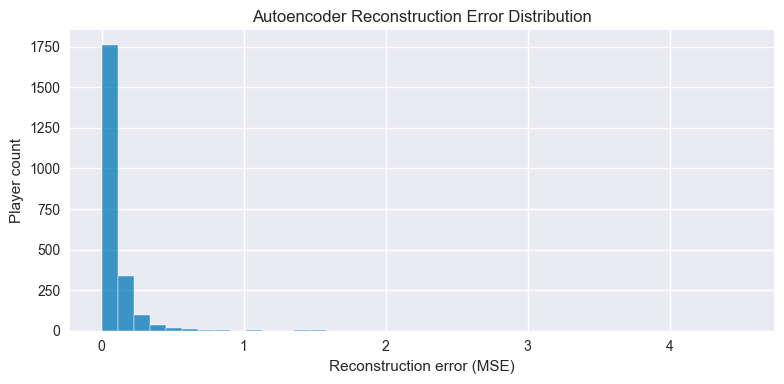

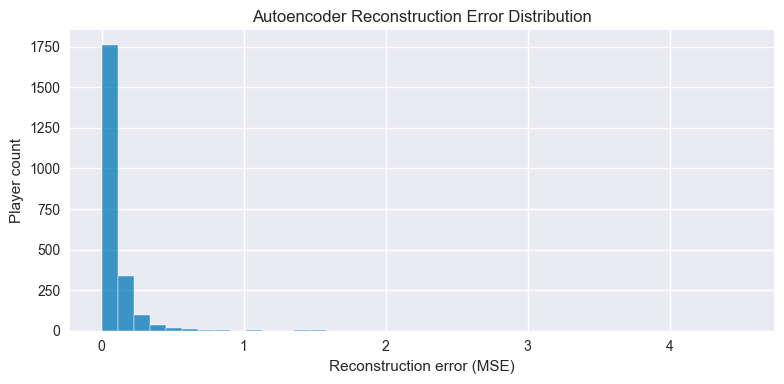

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(player_features['autoencoder_error'], bins=40, ax=ax, color='#0077b6')
ax.set_title('Autoencoder Reconstruction Error Distribution')
ax.set_xlabel('Reconstruction error (MSE)')
ax.set_ylabel('Player count')
fig.tight_layout()
recon_fig_path = FIG_DIR / 'autoencoder_recon_error_hist.png'
fig.savefig(recon_fig_path, dpi=300)
print(f'Saved histogram to {recon_fig_path}')
fig


## Compare autoencoder errors with MAD scores

Saved comparison scatter plot to C:\Users\nkany\OneDrive\Desktop\Desktop\Machine Learning\Project\figures\autoencoder_vs_mad_scatter.png


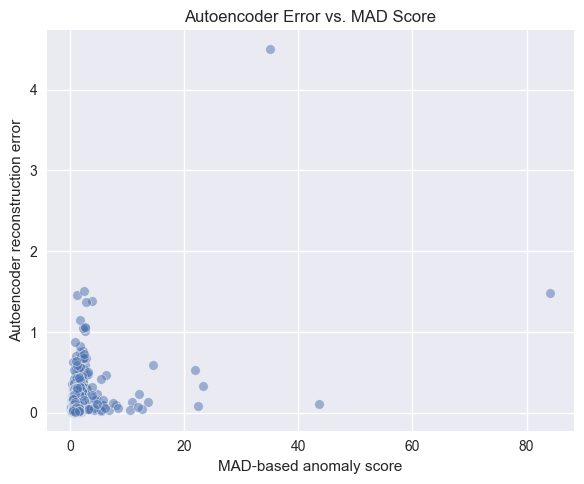

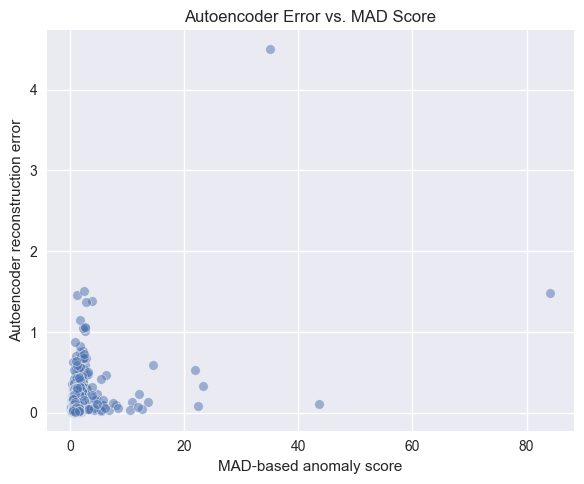

In [5]:
mad_features = [col for col in ['ppg', 'apg', 'rpg', 'impact_score', 'usage_proxy', 'assist_to_turnover', 'fg_pct'] if col in player_features.columns]
mad_result = core_out.detect_outliers_via_mad(player_features, mad_features, threshold=3.0)
mad_df = mad_result.dataframe.copy()
mad_df['autoencoder_error'] = player_features['autoencoder_error']

fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(data=mad_df, x='mad_score', y='autoencoder_error', ax=ax, alpha=0.5)
ax.set_title('Autoencoder Error vs. MAD Score')
ax.set_xlabel('MAD-based anomaly score')
ax.set_ylabel('Autoencoder reconstruction error')
fig.tight_layout()
scatter_path = FIG_DIR / 'autoencoder_vs_mad_scatter.png'
fig.savefig(scatter_path, dpi=300)
print(f'Saved comparison scatter plot to {scatter_path}')
fig


## Summary: Should this Add-on be Included in the Final Report?
Autoencoder-based detection offers a compelling non-linear perspective that can complement MAD/IsolationForest, but it introduces extra dependencies and interpretability overhead. It is best presented as an optional research extension unless the assessment explicitly rewards advanced modelling techniques.
